# Importation & lecture 

In [ ]:
import pandas as pd
import os

In [ ]:
# Chemin vers le dossier contenant les fichiers CSV
csv_path = os.path.join('.', 'csv')

# Charger l'index des partitions
partition_index = pd.read_csv('imputed_stage_index.csv')

# charger les informations générales sur les patients 
general_table = pd.read_csv('general_table.csv')


# Afficher les données pour le patient 1

In [ ]:

patient_id = partition_index['patientid'][0]
partition = partition_index['part'][0]
#afficher la ligne du patient dans la table générale
print(general_table[general_table['patientid'] == patient_id])

# Charger les données du premier patient depuis le fichier CSV correspondant
file_path = os.path.join(csv_path, f'part-{partition}.csv')
patient_data = pd.read_csv(file_path, usecols=['patientid', 'reldatetime', 'vm1', 'vm3', 'vm4', 'vm5', 'vm13', 'vm20', 'vm28', 'vm62', 'vm136', 'vm146', 'vm172', 'vm174', 'vm176', 'pm41', 'pm42', 'pm43', 'pm44', 'pm87'])
patient_data = patient_data[patient_data['patientid'] == patient_id]

# Calculer la moyenne et l'écart-type de la colonne 'vm1'
vm1_mean = patient_data['vm1'].mean()
vm1_std = patient_data['vm1'].std()

# Afficher les résultats
print(f'Mean of vm1 for patient {patient_id}: {vm1_mean}')
print(f'Standard deviation of vm1 for patient {patient_id}: {vm1_std}')

In [ ]:
#le nombre de données pour le patient 1
patient_data.shape


In [ ]:
patient_data.head()

In [ ]:
patient_data.describe()

# Classifier les données pour les patients

Circulatory state annotation
We annotated every 5-min interval of a patient’s stay with their current circulatory state using 3 types of variables: lactate (arterial and venous), MAP and presence of vasoactive/inotropic drugs. The state was established using a window of 45-min duration centered on the current time point. To reduce spurious calls due to transient states, in each such window all conditions had to be independently true for 30 min (not necessarily consecutive).

We defined the following three states:

Patient currently not in circulatory failure: if MAP is >65 mmHg, vasoactive/inotropic drugs are not present, and lactate is ≤2 mmol l–1.

Patient currently in circulatory failure: MAP is ≤65 mmHg, or (not exclusive) vasoactive/inotropic drugs are present and lactate is >2 mmol l–1.

Unknown/ambiguous: if any of the following conditions hold:

No MAP or (interpolated) lactate is available in the 45-min window

MAP or vasoactive/inotropic drug criterion is met, but lactate is ≤2 mmol l–1

To enable state annotation at all time points, we imputed lactate values between measurements. We linearly interpolated lactate values between measurements, unless the patient’s lactate value had passed the threshold of 2 mmol l–1 in either direction. If a patient’s state had changed, from either low to high lactate or vice versa, we linearly interpolated depending on the interval between the two measurements. If they were less than 6 h apart we interpolated for the full period. Otherwise, we forward/backward filled for a maximum of 3 h and the remaining time points were left missing.

To handle the starts/ends of the stay, we filled forward/backward. If the patient’s first/last measurement was ‘normal’ (under the threshold), we backward/forward filled indefinitely. If the measurement was abnormal, we filled backward/forward for up to 3 h.

As this imputation scheme implicitly used information from the future, it was only used for annotating (and subsequently labeling) time points. Adaptive imputation and feature generation for model development were performed independently and as described below without using future information.

In [ ]:
!pip install tqdm

In [ ]:
import pandas as pd
import os
import numpy as np

def interpolate_lactate(patient_data):
    patient_data['vm136'].interpolate(method='linear', inplace=True)
    patient_data['vm146'].interpolate(method='linear', inplace=True)
    return patient_data

def fill_missing_values(patient_data):
    patient_data.fillna(method='ffill', inplace=True)
    patient_data.fillna(method='bfill', inplace=True)
    return patient_data

def annotate_data(patient_data):
    # Calculer les états circulatoires pour chaque point de données
    patient_data['circulatory_state'] = "Unknown/ambiguous"

    for idx, row in patient_data.iterrows():
        not_in_failure_condition = (row['vm5'] > 65) & (row['vm136'] <= 2) & (row['vm146'] <= 2) & (row['pm41'] == 0) & (row['pm42'] == 0) & (row['pm43'] == 0) & (row['pm44'] == 0)
        in_failure_condition = (row['vm5'] <= 65) | (((row['vm136'] > 2) | (row['vm146'] > 2)) & ((row['pm41'] != 0) | (row['pm42'] != 0) | (row['pm43'] != 0) | (row['pm44'] != 0)))

        if not_in_failure_condition:
            patient_data.loc[idx, 'circulatory_state'] = "Stable"
        elif in_failure_condition:
            patient_data.loc[idx, 'circulatory_state'] = "Failure"

    return patient_data

# Charger l'index des partitions
partition_index = pd.read_csv('imputed_stage_index.csv')

# charger les informations générales 
general_table = pd.read_csv('general_table.csv')

# # Charger l'index des partitions
# partition_index = pd.read_csv('imputed_stage_index.csv')

# # charger les informations générales sur les patients
# general_table = pd.read_csv('general_table.csv')

# Créer une liste de tous les IDs de patients uniques
patient_ids = general_table['patientid'].unique()

# Initialiser une liste pour stocker les annotations de tous les patient
annotations = []

# Traiter chaque patient
for patient_id in patient_ids:
    if patient_id % 100 == 0:
        print(f"Traitement du patient {patient_id}/{patient_ids[-1]}")
    
    # Trouver l'index correspondant au patient dans l'index des partitions
    index = partition_index[partition_index['patientid'] == patient_id].index[0]

    # Récupérer le numéro de partition associé 
    partition = partition_index['part'][index]

    # Charger les données du patient
    file_path = os.path.join('csv', f'part-{partition}.csv')
    patient_data = pd.read_csv(file_path)
    patient_data = patient_data[patient_data['patientid'] == patient_id]

    # Sélectionner uniquement les colonnes utiles
    columns_of_interest = ['patientid', 'reldatetime', 'vm5', 'vm136', 'vm146', 'pm41', 'pm42', 'pm43', 'pm44']
    patient_data = patient_data[columns_of_interest]

    # Supprimer les doublons
    patient_data.drop_duplicates(inplace=True)

    # Traiter les données du patient
    patient_data = interpolate_lactate(patient_data)
    patient_data = fill_missing_values(patient_data)

    #ajouter annotation
    patient_data = annotate_data(patient_data)

    # Stocker les annotations pour le patient dans la liste globale
    patient_annotations = patient_data[['patientid', 'reldatetime', 'circulatory_state']]
    annotations.append(patient_annotations)

# Concaténer les annotations
all_annotations = pd.concat(annotations)

# Enregistrer df en CSV 
all_annotations.to_csv('patient_annotations.csv', index=False)

print("Le fichier 'patient_annotations.csv' a été créé avec succès.")



100%|██████████| 33905/33905 [5:48:31<00:00,  1.62it/s]        
Le fichier 'patient_annotations.csv' a été créé avec succès.

# Classification avec windowing

In [ ]:
import pandas as pd
from tqdm import tqdm

def get_window_indices(i, window_size):
    start_idx = max(0, i - window_size // 2)
    end_idx = min(len(df) - 1, i + window_size // 2)
    return start_idx, end_idx

def get_majority_state(window, min_element_same):
    state_count = window["circulatory_state"].value_counts()
    max_state = state_count.idxmax()
    max_state_count = state_count.max()

    if max_state == "Unknown/ambiguous" and max_state_count >= min_element_same:
        return "Unknown/ambiguous"
    elif max_state_count >= min_element_same:
        return max_state
    else:
        return "Stable"

# Lecture du fichier CSV
df = pd.read_csv("patient_annotations_all.csv", sep=",")

# Paramètres de la fenêtre
window_size_element = 9
min_element_same = 6

# Création d'une nouvelle colonne pour stocker les classes
df["class"] = ""

# Parcours des lignes avec la barre de progression
for i in tqdm(range(len(df))):
    if i != 0 and df.iloc[i]["patientid"] == df.iloc[i - 1]["patientid"]:
        start_idx, end_idx = get_window_indices(i, window_size_element)
        window = df.iloc[start_idx:end_idx + 1]
        df.at[i, "class"] = get_majority_state(window, min_element_same)
    else:
        df.at[i, "class"] = "Stable"

# Enregistrer le DataFrame dans un fichier CSV
df.to_csv('patient_classified_all_data.csv', index=False)

print("Le fichier 'patient_classified_all_data.csv' a été créé avec succès.")


100%|██████████| 28254426/28254426 [4:33:10<00:00, 1723.81it/s]  
Le fichier 'patient_classified_all_data.csv' a été créé avec succès.

In [ ]:
#eteindre pc forcer
import os
# os.system("shutdown /s /t 1")


# Traitement du fichier d'annotations

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Charger le fichier all_patient_annotations.csv
annotations = pd.read_csv('patient_classified_all_data.csv')

Afficher annotation pour un patient

In [ ]:
#afficher les deux premiers patients seulement
annotations_df = annotations[annotations['patientid'] ==2]

# Filtrer les données pour les patients stable, failure, and unknonwn
failure_data = annotations_df[annotations_df['class'] == 'Failure']
stable_data = annotations_df[annotations_df['class'] == 'Stable']
unknown_data = annotations_df[annotations_df['class'] == 'Unknown/ambiguous']

# Convertir 'reldatetime'  en minutes
failure_data['reldatetime'] = pd.to_timedelta(failure_data['reldatetime']).dt.total_seconds() / 60
stable_data['reldatetime'] = pd.to_timedelta(stable_data['reldatetime']).dt.total_seconds() / 60
unknown_data['reldatetime'] = pd.to_timedelta(unknown_data['reldatetime']).dt.total_seconds() / 60

#afficher sous forme de graphique si stable y =0, si failure y=1, si unknown y=-1
plt.figure(figsize=(20, 10))
plt.plot(failure_data['reldatetime'], np.ones(len(failure_data)), 'ro', label='Failure')
plt.plot(stable_data['reldatetime'], np.zeros(len(stable_data)), 'go', label='Stable')
plt.plot(unknown_data['reldatetime'], -np.ones(len(unknown_data)), 'bo', label='Unknown/ambiguous')
plt.legend()
plt.show()



In [ ]:
#afficher les deux premiers patients seulement
annotations_df = annotations[annotations['patientid'] ==5]

# Filtrer les données pour les patients stable, failure, and unknonwn
failure_data = annotations_df[annotations_df['class'] == 'Failure']
stable_data = annotations_df[annotations_df['class'] == 'Stable']
unknown_data = annotations_df[annotations_df['class'] == 'Unknown/ambiguous']

# Convertir 'reldatetime'  en minutes
failure_data['reldatetime'] = pd.to_timedelta(failure_data['reldatetime']).dt.total_seconds() / 60
stable_data['reldatetime'] = pd.to_timedelta(stable_data['reldatetime']).dt.total_seconds() / 60
unknown_data['reldatetime'] = pd.to_timedelta(unknown_data['reldatetime']).dt.total_seconds() / 60

#afficher sous forme de graphique si stable y =0, si failure y=1, si unknown y=-1
plt.figure(figsize=(20, 10))
plt.plot(failure_data['reldatetime'], np.ones(len(failure_data)), 'ro', label='Failure')
plt.plot(stable_data['reldatetime'], np.zeros(len(stable_data)), 'go', label='Stable')
plt.plot(unknown_data['reldatetime'], -np.ones(len(unknown_data)), 'bo', label='Unknown/ambiguous')
plt.legend()
plt.show()



Afficher des données générales

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculer le nombre de données par patient
data_per_patient = annotations.groupby('patientid').size()

#calculer le nombre de données
total_data = data_per_patient.sum()

# Afficher les statistiques
print(f"Nombre de données  :\n{total_data}")
print(f"Nombre de données par patient :\n{data_per_patient}")
#

Les patients et les états: est-ce qu'un patient est seulement stable ?

In [ ]:
import pandas as pd

# Charger le fichier all_patient_annotations.csv
annotations = pd.read_csv('patient_classified_all_data.csv')

# Compter le nombre de patients dans chaque état circulatoire par patient
circulatory_state_counts = annotations.groupby('patientid')['class'].value_counts().unstack(fill_value=0)

# Trouver les patients qui font uniquement stable, stable et failure, stable et unknown, et les trois
only_stable = circulatory_state_counts[(circulatory_state_counts['Stable'] > 0) & (circulatory_state_counts['Failure'] == 0) & (circulatory_state_counts['Unknown/ambiguous'] == 0)].shape[0]
stable_and_failure = circulatory_state_counts[(circulatory_state_counts['Stable'] > 0) & (circulatory_state_counts['Failure'] > 0) & (circulatory_state_counts['Unknown/ambiguous'] == 0)].shape[0]
stable_and_unknown = circulatory_state_counts[(circulatory_state_counts['Stable'] > 0) & (circulatory_state_counts['Failure'] == 0) & (circulatory_state_counts['Unknown/ambiguous'] > 0)].shape[0]
all_three = circulatory_state_counts[(circulatory_state_counts['Stable'] > 0) & (circulatory_state_counts['Failure'] > 0) & (circulatory_state_counts['Unknown/ambiguous'] > 0)].shape[0]

# Calculer les pourcentages
total_patients = circulatory_state_counts.shape[0]
only_stable_percentage = (only_stable / total_patients) * 100
stable_and_failure_percentage = (stable_and_failure / total_patients) * 100
stable_and_unknown_percentage = (stable_and_unknown / total_patients) * 100
all_three_percentage = (all_three / total_patients) * 100

# Afficher les pourcentages
print(f"Pourcentage de patients uniquement stable: {only_stable_percentage:.2f}%")
print(f"Pourcentage de patients stable et failure: {stable_and_failure_percentage:.2f}%")
print(f"Pourcentage de patients stable et unknown: {stable_and_unknown_percentage:.2f}%")
print(f"Pourcentage de patients avec les trois états: {all_three_percentage:.2f}%")

# Créer le graphique à secteurs
labels = ['Uniquement stable', 'Stable et défaillance', 'Stable et Inconnu', 'Les trois états']
sizes = [only_stable, stable_and_failure, stable_and_unknown, all_three]
colors = ['#ff9999','#66b3ff','#99ff99', '#ffcc99']
explode = (0.1, 0, 0, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Répartition des patients en fonction de leurs états circulatoires")

# Afficher le graphique
plt.show()



Répartition des états en fonction du temps, indépendamment du patient

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier 
annotations = pd.read_csv('patient_classified_all_data.csv')

# Compter le nombre d'occurrences pour chaque état 
circulatory_state_counts = annotations['class'].value_counts()

# Calculer le pourcentage de chaque état circulatoire
total_counts = circulatory_state_counts.sum()
stable_percentage = (circulatory_state_counts['Stable'] / total_counts) * 100
failure_percentage = (circulatory_state_counts['Failure'] / total_counts) * 100
unknown_percentage = (circulatory_state_counts['Unknown/ambiguous'] / total_counts) * 100

# # Vérifier que les pourcentages somment bien à 100
# assert round(stable_percentage + failure_percentage + unknown_percentage, 2) == 100.00

# Créer le graphique à secteurs
labels = ['Stable', 'Défaillance', 'Inconnu']
sizes = [stable_percentage, failure_percentage, unknown_percentage]
colors = ['#66b3ff','#ff9999', '#99ff99']
explode = (0.1, 0, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Répartition des états circulatoires")

# Afficher le graphique
plt.show()


Affichage des 100 premier 

In [ ]:

#sélectionner les 1000 premiers patients
annotations_df = annotations[annotations['patientid'] <= 100]

# Filtrer les données pour les patients en fonction de l'état
failure_data = annotations_df[annotations_df['class'] == 'Failure']
stable_data = annotations_df[annotations_df['class'] == 'Stable']
unknown_data = annotations_df[annotations_df['class'] == 'Unknown/ambiguous']

# Convertir 'reldatetime' en minutes
failure_data['reldatetime'] = pd.to_timedelta(failure_data['reldatetime']).dt.total_seconds() / 60
stable_data['reldatetime'] = pd.to_timedelta(stable_data['reldatetime']).dt.total_seconds() / 60
unknown_data['reldatetime'] = pd.to_timedelta(unknown_data['reldatetime']).dt.total_seconds() / 60

# Créer un graphique
plt.figure(figsize=(10, 6))
plt.scatter(stable_data['reldatetime'], stable_data['patientid'], s=5, alpha=0.5, color='blue', label='Stable')
plt.scatter(failure_data['reldatetime'], failure_data['patientid'], s=5, alpha=0.5, color='red', label='Failure')
plt.scatter(unknown_data['reldatetime'], unknown_data['patientid'], s=5, alpha=0.5, color='green', label='Unknown/ambiguous')
plt.xlabel('Temps relatif (minutes)')
plt.ylabel('Identifiant du patient')
plt.title("États circulatoires des patients en fonction du temps")
plt.grid(True)
plt.legend()

# Afficher le graphique
plt.show()

Quand apparait le premier failure pour les 100 premiers patients (reprend le df de la cellule précédente)

In [ ]:
# Identifier les patients en failure
failure_patients = annotations_df[annotations_df['class'] == 'Failure']['patientid'].unique()

# Calculer le moment relatif l'apparition de la première failure
failure_ratios = []
for patient_id in failure_patients:
    patient_data = annotations_df[annotations_df['patientid'] == patient_id]
    
    failure_time = patient_data[patient_data['class'] == 'Failure']['reldatetime'].min()
    # print(failure_time)
    treatment_duration = patient_data['reldatetime'].max() - patient_data['reldatetime'].min()
    
    # Calculer le ratio firstFailure / temps total
    failure_ratio = (failure_time / treatment_duration)
    failure_ratios.append(failure_ratio)

# Calculer la moyenne
average_failure_ratio = np.mean(failure_ratios)
average_failure_percentage = average_failure_ratio * 100
print(f"La failure apparaît en moyenne à {average_failure_percentage:.2f}% de la durée totale du traitement pour les patients en failure.")


# Traitement de 2 classes uniquement : stable et failure

supprimer les patients qui présentes des moments inconnues

In [ ]:
import pandas as pd

# Charger le fichier
annotations = pd.read_csv('patient_classified_all_data.csv')

# Identifier les patients qui ont au moins un moment inconnu
unknown_patients = annotations[annotations['class'] == 'Unknown/ambiguous']['patientid'].unique()
print(f"Nombre de patients avec au moins un moment inconnu: {len(unknown_patients)}")

# Filtrer données pour supprimer les états inconnus
filtered_annotations = annotations[~annotations['patientid'].isin(unknown_patients)]

# Vérifier que les états inconnus ont été supprimés
assert filtered_annotations['class'].str.contains('Unknown/ambiguous').sum() == 0

# Sauvegarder les données filtrées dans un nouveau fichier CSV
filtered_annotations.to_csv('patient_classified_filtered_data.csv', index=False)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier
annotations = pd.read_csv('patient_classified_filtered_data.csv')

# Compter le nombre de patients
total_patients = annotations['patientid'].nunique()

# Trouver les patients avec des moments de failure
failure_patients = annotations[annotations['class'] == 'Failure']['patientid'].unique()

# Calculer le nombre et le pourcentage de patients avec des moments de failure
failure_patients_count = len(failure_patients)
print(f"Nombre de patients avec des moments de failure: {failure_patients_count}")
failure_patients_percentage = (failure_patients_count / total_patients) * 100

# Calculer le nombre et le pourcentage de patients sans moments de failure
non_failure_patients_count = total_patients - failure_patients_count
print(f"Nombre de patients sans moments de failure: {non_failure_patients_count}")
non_failure_patients_percentage = (non_failure_patients_count / total_patients) * 100

# Créer le graphique à secteurs
labels = ['Avec Failure', 'Sans Failure']
sizes = [failure_patients_percentage, non_failure_patients_percentage]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Répartition des patients avec et sans moments de failure")

# Afficher le graphique
plt.show()


In [ ]:
# récupération des données failure
failure_data = annotations[annotations['class'] == 'Failure']
#calcul proportion failure
failure_percentage = (len(failure_data) / len(annotations)) * 100
print(f"Proportion de failure: {failure_percentage:.2f}%")

# récupération des données stable
stable_data = annotations[annotations['class'] == 'Stable']
#calcul proportion stable
stable_percentage = (len(stable_data) / len(annotations)) * 100
print(f"Proportion de stable: {stable_percentage:.2f}%")

c'est donc assez équilibré 

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

# Charger l'index des partitions
partition_index = pd.read_csv('imputed_stage_index.csv')

# charger les informations générales 
general_table = pd.read_csv('general_table.csv')

# Créer une liste de tous les IDs de patients uniques
annotations_df = pd.read_csv('patient_classified_filtered_data.csv')

#récupérer les numéros de patients uniques de annotations_df
patient_ids = annotations_df['patientid'].unique()

print(patient_ids)
# nombre de patients uniques
print(len(patient_ids))

# Initialiser une liste pour stocker les annotations de tous les patient
patient_annotations_list = []

# Traiter chaque patient
for patient_id in tqdm(patient_ids):
    
    # Trouver l'index correspondant au patient dans l'index des partitions
    index = partition_index[partition_index['patientid'] == patient_id].index[0]

    # Récupérer le numéro de partition associé 
    partition = partition_index['part'][index]

    # Charger les données du patient
    file_path = os.path.join('csv', f'part-{partition}.csv')
    patient_data = pd.read_csv(file_path)
    patient_data = patient_data[patient_data['patientid'] == patient_id]

    #merge avec les annotations pour ce patient contenu dans annotations_df
    patient_annotations = annotations_df[annotations_df['patientid'] == patient_id]
    patient_data = pd.merge(patient_annotations,patient_data , on='reldatetime', how='left')
    #delete patientid_y
    patient_data = patient_data.drop(columns=['patientid_y'])
    #rename patientid_x to patientid
    patient_data = patient_data.rename(columns={'patientid_x': 'patientid'})

    #sauvegarder les données du patient
    patient_annotations_list.append(patient_data)




In [ ]:
annotations = pd.concat(patient_annotations_list)
annotations.to_csv('patient_data_222.csv', index=False)

In [ ]:
#compter le nombre de patients dans patient_data_22.csv
annotations = pd.read_csv('patient_data_222.csv')
annotations['patientid'].nunique()


### kmeans

tout d'abord, un test: en utilisant les annotations

tout d'abord avec deux clusters

In [ ]:
data = data[data['patientid'] <= 100]
#nombre patient uni ue
data['patientid'].nunique()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Charger les données
data = pd.read_csv('patient_data_222.csv')

# Choisir les colonnes pour le clustering
columns_to_cluster = ['vm1', 'vm3', 'vm4', 'vm5', 'vm13', 'vm20', 'vm28', 'vm62', 'vm136', 'vm146', 'vm172', 'vm174', 'vm176', 'pm41', 'pm42', 'pm43', 'pm44', 'pm87']
data_to_cluster = data[columns_to_cluster]

# Normaliser les données pour une meilleure performance du clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_cluster)

# Choisir le nombre de clusters
n_clusters = 2

# Initialiser le modèle de clustering K-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Effectuer le clustering sur toutes les données
cluster_labels = kmeans.fit_predict(scaled_data)

# Ajouter les labels de cluster au DataFrame d'origine
data['cluster'] = cluster_labels

# Afficher les résultats
print(data)

# Sauvegarder les résultats dans un fichier CSV
data.to_csv('patient_clusters_no_window.csv', index=False)


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def classification_percentage(result, true_labels):
    # Créer la matrice de confusion
    conf_mat = confusion_matrix(result, true_labels)
    # print(conf_mat) 

    # Créer une correspondance entre les groupes et les classes
    mapping = {}
    for cluster in range(conf_mat.shape[0]):
        class_idx = np.argmax(conf_mat[cluster, :])
        mapping[cluster] = class_idx

    # Appliquer la cartographie au résultat
    mapped_result = np.array([mapping[cluster] for cluster in result])
    # print(mapping)

    # Calculer le pourcentage de classification correct
    correct_classification = np.sum(mapped_result == true_labels)
    total_data_points = len(true_labels)
    percentage = correct_classification / total_data_points * 100

    return percentage


In [ ]:
class_mapping = {'Failure': 0, 'Stable': 1}

true_labels = data['class'].map(class_mapping)

classification_pct = classification_percentage(cluster_labels, true_labels)
print("Correct classification percentage:", classification_pct)

In [ ]:
from sklearn.metrics import adjusted_rand_score, silhouette_score, v_measure_score
from sklearn.metrics.pairwise import euclidean_distances

# Charger les données des étiquettes réelles
annotations = pd.read_csv('patient_classified_filtered_data.csv')

# Fusionner les résultatss
results = data.merge(annotations[['patientid', 'reldatetime', 'class']], on=['patientid', 'reldatetime'], suffixes=('', '_true'))

# Calculer l'indice de Rand ajusté (ARI)
ari = adjusted_rand_score(results['class'], results['cluster'])
print(f"Indice de Rand ajusté: {ari:.4f}")


# Obtenir les étiquettes de cluster valides 
valid_labels = data['cluster']

from sklearn.metrics import silhouette_score

# Définir la taille de l'échantillon pour l'approximation--> mille points aléatoires
sample_size = 1000

# Calculer le coefficient de silhouette pour les données valides en utilisant l'approximation
silhouette = silhouette_score(scaled_data, valid_labels, metric='euclidean', sample_size=sample_size)
print(f"Coefficient de silhouette (approximatif): {silhouette:.4f}")


# Calculer la mesure V
v_measure = v_measure_score(results['class'], results['cluster'])
print(f"Mesure V: {v_measure:.4f}")


Dans ce cas, avec 79 534 points de données, --> matrice de distances de taille 79 534 x 79 534-->47,1 GiB de mémoire 

# Quel est le meilleure K cluster ? 

In [ ]:
from tqdm import tqdm

### [data['patientid'] <= 100] --> 51 patient

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
#import tqdm


# Charger les données
data = pd.read_csv('patient_data_222.csv')

# Sélectionner les 10 premiers patients (51 patient)
data = data[data['patientid'] <= 100]

# Choisir les colonnes pour le clustering
columns_to_cluster = ['vm1', 'vm3', 'vm4', 'vm5', 'vm13', 'vm20', 'vm28', 'vm62', 'vm136', 'vm146', 'vm172', 'vm174', 'vm176', 'pm41', 'pm42', 'pm43', 'pm44', 'pm87']
data_to_cluster = data[columns_to_cluster]

# Normaliser les données pour une meilleure performance du clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_cluster)



In [ ]:
# Calculer la somme des carrés des distances intra-cluster pour différents nombres de clusters
inertias = []
max_clusters = 80
kmeans_models = []
predictions = []

for n_clusters in tqdm(range(1, max_clusters + 1)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)
    kmeans_models.append(kmeans)
    predictions.append(kmeans.predict(scaled_data))
    
# Create an empty list to store the classification percentages
classification_percentages = []

class_mapping = {'Failure': 0, 'Stable': 1}

true_labels = data['class'].map(class_mapping)


for cluster_labels in predictions:
    # Calculer le pourcentage de classification correct
    classification_pct = classification_percentage(cluster_labels, true_labels)
    # Ajouter le pourcentage à la liste
    classification_percentages.append(classification_pct)

# Trouver l'indice du modèle ayant le pourcentage de classification correcte le plus élevé
best_model_index = np.argmax(classification_percentages)

print(f"The best number of clusters is: {best_model_index + 1}")
print(f"Correct classification percentage: {classification_percentages[best_model_index]}")

plt.figure()
plt.plot(range(1, max_clusters + 1), classification_percentages, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Correct classification percentage')
plt.title('Correct classification percentage for different numbers of clusters')
plt.grid()
plt.show()

# Calculate the ratios inertias
ratios = []
for i in tqdm(range(1, len(inertias) - 1)):
    diff_inertia = inertias[i - 1] - inertias[i]
    diff_next_inertia = inertias[i] - inertias[i + 1]
    distance = np.sqrt((i - (i + 1))**2 + (diff_inertia - diff_next_inertia)**2)
    ratio = diff_next_inertia / distance
    ratios.append(ratio)

elbow_index = np.argmax(ratios) + 1

print(f"Le meilleur nombre de clusters est : {elbow_index + 1}")

plt.plot(range(1, len(inertias) + 1), inertias, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid()
plt.show()

### [data['patientid'] <= 1000] --> 569 patient

In [ ]:
#compte patient unique
print(data[data['patientid'] <= 1000].nunique())

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Charger les données
data = pd.read_csv('patient_data_222.csv')

# Sélectionner les 1000 premiers patients (51 patients)
data = data[data['patientid'] <= 1000]

# Choisir les colonnes pour le clustering
columns_to_cluster = ['vm1', 'vm3', 'vm4', 'vm5', 'vm13', 'vm20', 'vm28', 'vm62', 'vm136', 'vm146', 'vm172', 'vm174', 'vm176', 'pm41', 'pm42', 'pm43', 'pm44', 'pm87']
data_to_cluster = data[columns_to_cluster]

# Normaliser les données pour une meilleure performance du clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_cluster)

# Calculer la somme des carrés des distances intra-cluster pour différents nombres de clusters
inertias_1000 = []
max_clusters_1000 = 80
kmeans_models_1000 = []
predictions_1000 = []

for n_clusters in tqdm(range(1, max_clusters_1000 + 1)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    inertias_1000.append(kmeans.inertia_)
    kmeans_models_1000.append(kmeans)
    predictions_1000.append(kmeans.predict(scaled_data))



    
# Create an empty list to store the classification percentages
classification_percentages_1000 = []

class_mapping = {'Failure': 0, 'Stable': 1}

true_labels = data['class'].map(class_mapping)

# Loop through the predictions of each clustering model
for cluster_labels in predictions_1000:
    # Calculate the correct classification percentage
    classification_pct = classification_percentage(cluster_labels, true_labels)
    # Append the percentage to the list
    classification_percentages_1000.append(classification_pct)

# Find the index of the model with the highest correct classification percentage
best_model_index_1000 = np.argmax(classification_percentages_1000)

print(f"The best number of clusters is: {best_model_index_1000 + 1}")
print(f"Correct classification percentage: {classification_percentages_1000[best_model_index_1000]}")

plt.figure()
plt.plot(range(1, max_clusters_1000 + 1), classification_percentages_1000, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Correct classification percentage')
plt.title('Correct classification percentage for different numbers of clusters')
plt.grid()
plt.show()




In [ ]:
# Calculate the ratios for each point
ratios = []
for i in tqdm(range(1, len(inertias_1000) - 1)):
    diff_inertia = inertias_1000[i - 1] - inertias_1000[i]
    diff_next_inertia = inertias_1000[i] - inertias_1000[i + 1]
    distance = np.sqrt((i - (i + 1))**2 + (diff_inertia - diff_next_inertia)**2)
    ratio = diff_next_inertia / distance
    ratios.append(ratio)

# Find the index of the "elbow" point with the highest ratio
elbow_index = np.argmax(ratios) + 1

print(f"Le meilleur nombre de clusters est : {elbow_index + 1}")

plt.plot(range(1, len(inertias_1000) + 1), inertias_1000, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid()
plt.show()


MiniBatchKMeans

In [ ]:
from tqdm import tqdm
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

# avec les 1000 premiers patients (51 patients)
# Assuming scaled_data is already defined
# Calculate the sum of squares of intra-cluster distances for different numbers of clusters
inertias_MiniBatchKMeans = []
max_clusters = 80
kmeans_models_MiniBatchKMeans = []
predictions_MiniBatchKMeans = []

for n_clusters in tqdm(range(1, max_clusters + 1)):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=2048 )
    minibatch_kmeans.fit(scaled_data)
    # kmeans.fit(scaled_data)
    inertias_MiniBatchKMeans.append(minibatch_kmeans.inertia_)
    kmeans_models_MiniBatchKMeans.append(minibatch_kmeans)
    predictions_MiniBatchKMeans.append(minibatch_kmeans.predict(scaled_data))

In [ ]:

# Create an empty list to store the classification percentages
classification_percentages_MiniBatchKMeans = []


class_mapping = {'Failure': 0, 'Stable': 1}

true_labels = data['class'].map(class_mapping)

# Loop through the predictions of each clustering model
for cluster_labels in predictions_MiniBatchKMeans:
    # Calculate the correct classification percentage
    classification_pct = classification_percentage(cluster_labels, true_labels)
    # Append the percentage to the list
    classification_percentages_MiniBatchKMeans.append(classification_pct)

# Find the index of the model with the highest correct classification percentage
best_model_index_MiniBatchKMeans = np.argmax(classification_percentages_MiniBatchKMeans)

# Print the best number of clusters and its classification percentage
print(f"The best number of clusters is: {best_model_index_MiniBatchKMeans + 1}")
print(f"Correct classification percentage: {classification_percentages_MiniBatchKMeans[best_model_index_MiniBatchKMeans]}")

# Plot the correct classification percentages for different numbers of clusters
plt.figure()
plt.plot(range(1, max_clusters + 1), classification_percentages_MiniBatchKMeans, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Correct classification percentage')
plt.title('Correct classification percentage for different numbers of clusters')
plt.grid()
plt.show()


# Calculate the ratios for each point
ratios = []
for i in tqdm(range(1, len(inertias_MiniBatchKMeans) - 1)):
    diff_inertia = inertias_MiniBatchKMeans[i - 1] - inertias_MiniBatchKMeans[i]
    diff_next_inertia = inertias_MiniBatchKMeans[i] - inertias_MiniBatchKMeans[i + 1]
    distance = np.sqrt((i - (i + 1))**2 + (diff_inertia - diff_next_inertia)**2)
    ratio = diff_next_inertia / distance
    ratios.append(ratio)

# Find the index of the "elbow" point with the highest ratio
elbow_index = np.argmax(ratios) + 1

print(f"Le meilleur nombre de clusters est : {elbow_index + 1}")

# Visualize the results with the elbow method
plt.plot(range(1, len(inertias_MiniBatchKMeans) + 1), inertias_MiniBatchKMeans, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid()
plt.show()


### minibatchKmeans data[data['patientid'] <= 100]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
#import tqdm


# Charger les données
data = pd.read_csv('patient_data_222.csv')

# Sélectionner les 100 premiers patients (51 patient)
data = data[data['patientid'] <= 100]

# Choisir les colonnes pour le clustering
columns_to_cluster = ['vm1', 'vm3', 'vm4', 'vm5', 'vm13', 'vm20', 'vm28', 'vm62', 'vm136', 'vm146', 'vm172', 'vm174', 'vm176', 'pm41', 'pm42', 'pm43', 'pm44', 'pm87']
data_to_cluster = data[columns_to_cluster]

# Normaliser les données pour une meilleure performance du clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_cluster)
from sklearn.cluster import MiniBatchKMeans

# Calculate the sum of squares of intra-cluster distances for different numbers of clusters
inertias_mini_10 = []
max_clusters = 80
kmeans_models_mini_10 = []
predictions_mini_10 = []

for n_clusters in tqdm(range(1, max_clusters + 1)):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=2048 )
    minibatch_kmeans.fit(scaled_data)
    # kmeans.fit(scaled_data)
    inertias_mini_10.append(minibatch_kmeans.inertia_)
    kmeans_models_mini_10.append(minibatch_kmeans)
    predictions_mini_10.append(minibatch_kmeans.predict(scaled_data))

In [ ]:
# Create an empty list to store the classification percentages
classification_percentages_mini_10 = []


class_mapping = {'Failure': 0, 'Stable': 1}

true_labels = data['class'].map(class_mapping)

# Loop through the predictions of each clustering model
for cluster_labels in predictions_mini_10:
    # Calculate the correct classification percentage
    classification_pct = classification_percentage(cluster_labels, true_labels)
    # Append the percentage to the list
    classification_percentages_mini_10.append(classification_pct)

# Find the index of the model with the highest correct classification percentage
best_model_index_mini_10 = np.argmax(classification_percentages_mini_10)

# Print the best number of clusters and its classification percentage
print(f"The best number of clusters is: {best_model_index_mini_10 + 1}")
print(f"Correct classification percentage: {classification_percentages_mini_10[best_model_index_mini_10]}")

# Plot the correct classification percentages for different numbers of clusters
plt.figure()
plt.plot(range(1, max_clusters + 1), classification_percentages_mini_10, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Correct classification percentage')
plt.title('Correct classification percentage for different numbers of clusters')
plt.grid()
plt.show()

# Calculate the ratios for each point
ratios = []
for i in tqdm(range(1, len(inertias_mini_10) - 1)):
    diff_inertia = inertias_mini_10[i - 1] - inertias_mini_10[i]
    diff_next_inertia = inertias_mini_10[i] - inertias_mini_10[i + 1]
    distance = np.sqrt((i - (i + 1))**2 + (diff_inertia - diff_next_inertia)**2)
    ratio = diff_next_inertia / distance
    ratios.append(ratio)

# Find the index of the "elbow" point with the highest ratio
elbow_index = np.argmax(ratios) + 1

# Display the best number of clusters
print(f"Le meilleur nombre de clusters est : {elbow_index + 1}")

# Visualize the results with the elbow method
plt.plot(range(1, len(inertias_mini_10) + 1), inertias_mini_10, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid()
plt.show()


### minibatch_kmeans Full

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
#import tqdm


# Charger les données
data = pd.read_csv('patient_data_222.csv')

# Choisir les colonnes pour le clustering
columns_to_cluster = ['vm1', 'vm3', 'vm4', 'vm5', 'vm13', 'vm20', 'vm28', 'vm62', 'vm136', 'vm146', 'vm172', 'vm174', 'vm176', 'pm41', 'pm42', 'pm43', 'pm44', 'pm87']
data_to_cluster = data[columns_to_cluster]

# Normaliser les données pour une meilleure performance du clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_cluster)
from sklearn.cluster import MiniBatchKMeans


# Calculate the sum of squares of intra-cluster distances for different numbers of clusters
inertias_mini_full = []
max_clusters = 80
kmeans_models_mini_full = []
predictions_mini_full = []

for n_clusters in tqdm(range(1, max_clusters + 1)):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=2048 )
    minibatch_kmeans.fit(scaled_data)
    # kmeans.fit(scaled_data)
    inertias_mini_full.append(minibatch_kmeans.inertia_)
    kmeans_models_mini_full.append(minibatch_kmeans)
    predictions_mini_full.append(minibatch_kmeans.predict(scaled_data))

In [ ]:

# Create an empty list to store the classification percentages
classification_percentages_mini_full = []


class_mapping = {'Failure': 0, 'Stable': 1}

true_labels = data['class'].map(class_mapping)

# Loop through the predictions of each clustering model
for cluster_labels in predictions_mini_full:
    # Calculate the correct classification percentage
    classification_pct = classification_percentage(cluster_labels, true_labels)
    # Append the percentage to the list
    classification_percentages_mini_full.append(classification_pct)

# Find the index of the model with the highest correct classification percentage
best_model_index_mini_full = np.argmax(classification_percentages_mini_full)

# Print the best number of clusters and its classification percentage
print(f"The best number of clusters is: {best_model_index_mini_full + 1}")
print(f"Correct classification percentage: {classification_percentages_mini_full[best_model_index_mini_full]}")

# Plot the correct classification percentages for different numbers of clusters
plt.figure()
plt.plot(range(1, max_clusters + 1), classification_percentages_mini_full, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Correct classification percentage')
plt.title('Correct classification percentage for different numbers of clusters')
plt.grid()
plt.show()


# Calculate the ratios for each point
ratios = []
for i in tqdm(range(1, len(inertias_mini_full) - 1)):
    diff_inertia = inertias_mini_full[i - 1] - inertias_mini_full[i]
    diff_next_inertia = inertias_mini_full[i] - inertias_mini_full[i + 1]
    distance = np.sqrt((i - (i + 1))**2 + (diff_inertia - diff_next_inertia)**2)
    ratio = diff_next_inertia / distance
    ratios.append(ratio)

# Find the index of the "elbow" point with the highest ratio
elbow_index = np.argmax(ratios) + 1

# Display the best number of clusters
print(f"Le meilleur nombre de clusters est : {elbow_index + 1}")

# Visualize the results with the elbow method
plt.plot(range(1, len(inertias_mini_full) + 1), inertias_mini_full, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid()
plt.show()


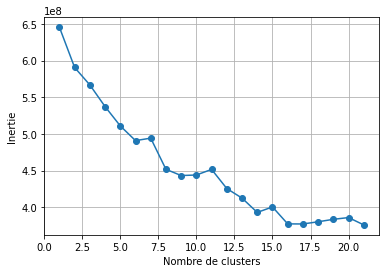

# Avec données  processed_data - test si la chronologie est bénéfique

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
#import tqdm


# Charger les données
data = pd.read_csv('processed_data.csv')


In [ ]:
#afficher nombre de ligne
print(f"Nombre de ligne  :{data.shape[0]}")
#supprimer les lignes avec des valeurs manquantes
data = data.dropna()
print(f"Nombre de ligne après suppression de lignes avec valeurs manques :{data.shape[0]}")

In [ ]:
# Choisir les colonnes pour le clustering
columns_to_cluster = ['vm1', 'vm3', 'vm4', 'vm5', 'vm13', 'vm20', 'vm28', 'vm62', 'vm136', 'vm146', 'vm172', 'vm174', 'vm176', 'pm41', 'pm42', 'pm43', 'pm44', 'pm87']
data_to_cluster = data[columns_to_cluster]

# Normaliser les données pour une meilleure performance du clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_cluster)



In [ ]:
# Calculer la somme des carrés des distances intra-cluster pour différents nombres de clusters
inertias = []
max_clusters = 80
kmeans_models = []
predictions = []

for n_clusters in tqdm(range(1, max_clusters + 1)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)
    kmeans_models.append(kmeans)
    predictions.append(kmeans.predict(scaled_data))
    
# Create an empty list to store the classification percentages
classification_percentages = []

class_mapping = {'Failure': 0, 'Stable': 1}

true_labels = data['class'].map(class_mapping)

# Loop through the predictions of each clustering model
for cluster_labels in predictions:
    # Calculate the correct classification percentage
    classification_pct = classification_percentage(cluster_labels, true_labels)
    # Append the percentage to the list
    classification_percentages.append(classification_pct)

# Find the index of the model with the highest correct classification percentage
best_model_index = np.argmax(classification_percentages)

# Print the best number of clusters and its classification percentage
print(f"The best number of clusters is: {best_model_index + 1}")
print(f"Correct classification percentage: {classification_percentages[best_model_index]}")

# Plot the correct classification percentages for different numbers of clusters
plt.figure()
plt.plot(range(1, max_clusters + 1), classification_percentages, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Correct classification percentage')
plt.title('Correct classification percentage for different numbers of clusters')
plt.grid()
plt.show()

# Calculate the ratios for each point
ratios = []
for i in tqdm(range(1, len(inertias) - 1)):
    diff_inertia = inertias[i - 1] - inertias[i]
    diff_next_inertia = inertias[i] - inertias[i + 1]
    distance = np.sqrt((i - (i + 1))**2 + (diff_inertia - diff_next_inertia)**2)
    ratio = diff_next_inertia / distance
    ratios.append(ratio)

# Find the index of the "elbow" point with the highest ratio
elbow_index = np.argmax(ratios) + 1

# Display the best number of clusters
print(f"Le meilleur nombre de clusters est : {elbow_index + 1}")

# Visualize the results with the elbow method
plt.plot(range(1, len(inertias) + 1), inertias, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid()
plt.show()

Avec toutes les donnnées (duplicata --> pour garder la chronologie)

In [ ]:
# choisir toutes les colonnes sauf les 4 premières (166 colones en tout)
columns_to_cluster = data.columns[4:]
data_to_cluster = data[columns_to_cluster]

# Normaliser les données pour une meilleure performance du clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_cluster)

In [ ]:
# Calculer la somme des carrés des distances intra-cluster pour différents nombres de clusters
inertias = []
max_clusters = 80
kmeans_models = []
predictions = []

for n_clusters in tqdm(range(1, max_clusters + 1)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)
    kmeans_models.append(kmeans)
    predictions.append(kmeans.predict(scaled_data))
    
# Create an empty list to store the classification percentages
classification_percentages = []

class_mapping = {'Failure': 0, 'Stable': 1}

true_labels = data['class'].map(class_mapping)

# Loop through the predictions of each clustering model
for cluster_labels in predictions:
    # Calculate the correct classification percentage
    classification_pct = classification_percentage(cluster_labels, true_labels)
    # Append the percentage to the list
    classification_percentages.append(classification_pct)

# Find the index of the model with the highest correct classification percentage
best_model_index = np.argmax(classification_percentages)

# Print the best number of clusters and its classification percentage
print(f"The best number of clusters is: {best_model_index + 1}")
print(f"Correct classification percentage: {classification_percentages[best_model_index]}")

# Plot the correct classification percentages for different numbers of clusters
plt.figure()
plt.plot(range(1, max_clusters + 1), classification_percentages, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Correct classification percentage')
plt.title('Correct classification percentage for different numbers of clusters')
plt.grid()
plt.show()

# Calculate the ratios for each point
ratios = []
for i in tqdm(range(1, len(inertias) - 1)):
    diff_inertia = inertias[i - 1] - inertias[i]
    diff_next_inertia = inertias[i] - inertias[i + 1]
    distance = np.sqrt((i - (i + 1))**2 + (diff_inertia - diff_next_inertia)**2)
    ratio = diff_next_inertia / distance
    ratios.append(ratio)

# Find the index of the "elbow" point with the highest ratio
elbow_index = np.argmax(ratios) + 1

# Display the best number of clusters
print(f"Le meilleur nombre de clusters est : {elbow_index + 1}")

# Visualize the results with the elbow method
plt.plot(range(1, len(inertias) + 1), inertias, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid()
plt.show()

In [ ]:
# choisir toutes les colonnes sauf les 4 premières (166 colones en tout)
columns_to_cluster = data.columns[4:]

specified_columns = ['vm1', 'vm3', 'vm4', 'vm5', 'vm13', 'vm20', 'vm28', 'vm62', 'vm136', 'vm146', 'vm172', 'vm174', 'vm176', 'pm41', 'pm42', 'pm43', 'pm44', 'pm87']
remaining_columns = [col for col in columns_to_cluster if col not in specified_columns]

columns_before_35 = remaining_columns[:72]
columns_after_35 = remaining_columns[72:]

rearranged_columns = list(columns_before_35) + specified_columns + list(columns_after_35)


data_to_cluster = data[rearranged_columns]

#sauvegarder les données
data_to_cluster.to_csv('data processed arranged.csv', index=False)

# # Normaliser les données pour une meilleure performance du clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_cluster)



In [ ]:
# Calculer la somme des carrés des distances intra-cluster pour différents nombres de clusters
inertias = []
max_clusters = 80
kmeans_models = []
predictions = []

for n_clusters in tqdm(range(1, max_clusters + 1)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)
    kmeans_models.append(kmeans)
    predictions.append(kmeans.predict(scaled_data))
    
# Create an empty list to store the classification percentages
classification_percentages = []

class_mapping = {'Failure': 0, 'Stable': 1}

true_labels = data['class'].map(class_mapping)

# Loop through the predictions of each clustering model
for cluster_labels in predictions:
    # Calculate the correct classification percentage
    classification_pct = classification_percentage(cluster_labels, true_labels)
    # Append the percentage to the list
    classification_percentages.append(classification_pct)

# Find the index of the model with the highest correct classification percentage
best_model_index = np.argmax(classification_percentages)

# Print the best number of clusters and its classification percentage
print(f"The best number of clusters is: {best_model_index + 1}")
print(f"Correct classification percentage: {classification_percentages[best_model_index]}")

# Plot the correct classification percentages for different numbers of clusters
plt.figure()
plt.plot(range(1, max_clusters + 1), classification_percentages, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Correct classification percentage')
plt.title('Correct classification percentage for different numbers of clusters')
plt.grid()
plt.show()

# Calculate the ratios for each point
ratios = []
for i in tqdm(range(1, len(inertias) - 1)):
    diff_inertia = inertias[i - 1] - inertias[i]
    diff_next_inertia = inertias[i] - inertias[i + 1]
    distance = np.sqrt((i - (i + 1))**2 + (diff_inertia - diff_next_inertia)**2)
    ratio = diff_next_inertia / distance
    ratios.append(ratio)

# Find the index of the "elbow" point with the highest ratio
elbow_index = np.argmax(ratios) + 1

# Display the best number of clusters
print(f"Le meilleur nombre de clusters est : {elbow_index + 1}")

# Visualize the results with the elbow method
plt.plot(range(1, len(inertias) + 1), inertias, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.grid()
plt.show()

# DBSCAN

DBSCAN

In [ ]:
def classification_percentage_dbscan(result, true_labels):
    # Create the confusion matrix
    conf_mat = confusion_matrix(result, true_labels)

    #supprimer la première colonne 
    conf_mat = conf_mat[:, 1:]
    # Create a mapping between clusters and classes
    mapping = {}
    for cluster in range(conf_mat.shape[0]):
        if cluster == -1:
            # Assign -1 label for noise/outliers
            mapping[cluster] = -1
        else:
            class_idx = np.argmax(conf_mat[cluster, :])
            mapping[cluster] = class_idx

    # Apply the mapping to the result
    mapped_result = np.array([mapping.get(cluster, -1) for cluster in result])

    # Calculate the correct classification percentage
    correct_classification = np.sum(mapped_result[mapped_result != -1] == true_labels[mapped_result != -1])
    non_noise_percentage = (correct_classification / len(true_labels[mapped_result != -1])) * 100

    #print pourcentage of noise
    print(f"Pourcentage de bruit : {(len(mapped_result[mapped_result == -1]) / len(mapped_result)) * 100}")
   

    return non_noise_percentage

In [59]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Normalize the data for better clustering performance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_cluster)

# Normalize the data for better clustering performance
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_cluster)


# Set up the range of values for eps and min_samples
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]  
min_samples_values = [5, 10, 15,  20, 25, 30, 35, 40, 45, 50]  

# Store the best clustering performance and corresponding parameters
best_classification_pct = 0.0
best_eps = 0.0
best_min_samples = 0

# Loop through different combinations of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        # Set up and fit the DBSCAN model
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(scaled_data)

        # Retrieve the cluster labels
        cluster_labels = dbscan.labels_

        # Evaluate the clustering performance
        classification_pct = classification_percentage_dbscan(cluster_labels, true_labels)

        # Print the results for the current combination
        print(f"eps={eps}, min_samples={min_samples}: Correct classification percentage: {classification_pct}")

        #nombre de cluster 
        print(f"Nombre de cluster : {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")
        print("---------------------")

        # Update the best clustering performance if applicable
        if classification_pct > best_classification_pct:
            best_classification_pct = classification_pct
            best_eps = eps
            best_min_samples = min_samples

# Print the best clustering performance and corresponding parameters
print("Best results:")
print(f"eps={best_eps}, min_samples={best_min_samples}: Correct classification percentage: {best_classification_pct}")




Pourcentage de bruit : 16.74378253325622
eps=0.5, min_samples=5: Correct classification percentage: 95.36976909252911
Nombre de cluster : 1682
---------------------
Pourcentage de bruit : 29.48047375964996
eps=0.5, min_samples=10: Correct classification percentage: 94.68325993545741
Nombre de cluster : 948
---------------------
Pourcentage de bruit : 39.80813237106143
eps=0.5, min_samples=15: Correct classification percentage: 95.23739895139222
Nombre de cluster : 617
---------------------
Pourcentage de bruit : 46.84034500968139
eps=0.5, min_samples=20: Correct classification percentage: 95.73320719016083
Nombre de cluster : 463
---------------------
Pourcentage de bruit : 54.48738904116478
eps=0.5, min_samples=25: Correct classification percentage: 95.39477319188906
Nombre de cluster : 307
---------------------
Pourcentage de bruit : 58.89430935197526
eps=0.5, min_samples=30: Correct classification percentage: 95.74220781206986
Nombre de cluster : 232
---------------------
Pourcentag

MemoryError: Unable to allocate 1.00 GiB for an array with shape (1687, 79534) and data type float64

In [40]:
print(confusion_matrix(cluster_labels, true_labels))

#afficher les données la matrice de 



[[    0   440   914 ...     0     0     0]
 [    0  4796 68410 ...     0     0     0]
 [    0    22  1549 ...     0     0     0]
 ...
 [    0    76     0 ...     0     0     0]
 [    0     0   110 ...     0     0     0]
 [    0    12     4 ...     0     0     0]]
[[    0   440   914 ...     0     0     0]
 [    0  4796 68410 ...     0     0     0]
 [    0    22  1549 ...     0     0     0]
 ...
 [    0    76     0 ...     0     0     0]
 [    0     0   110 ...     0     0     0]
 [    0    12     4 ...     0     0     0]]


In [ ]:
# Evaluate the clustering performance
non_noise_percentage = classification_percentage_dbscan(cluster_labels, true_labels)
print(f"Percentage of non-noise data points: {non_noise_percentage}%")


In [11]:
#afficher le nombre de clusters
print(f"Nombre de clusters : {len(np.unique(cluster_labels))}")

Nombre de clusters : 1683
